# Investigating the correlation between ethnobonical usage at climatically-related species

### Import modules

In [1]:
from collections import defaultdict
from itertools import combinations
import random

import logging
import pandas as pd
from tqdm import tqdm
import numpy as np
    
# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from statannot import add_stat_annotation

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline

In [3]:
sns.set(context='poster')
mpl.rcParams['figure.dpi'] = 400

In [4]:
logging.disable()
pd.options.mode.chained_assignment = None

In [5]:
DATA_DIR = '../data/processed'

### Load plant-disease evidences

In [6]:
collapsed_plant_disease_df = pd.read_csv(
    f'{DATA_DIR}/plant_disease_collapsed.tsv.gz',
    compression='gzip',
    sep='\t',
    low_memory=False
)

In [7]:
literature_data = collapsed_plant_disease_df[
    collapsed_plant_disease_df['database'] == 'bern2'
]

plant_lit_ids = set(literature_data['plant_curie'].to_list())

literature_data.shape, len(plant_lit_ids)

((129539, 5), 4413)

In [8]:
database_data = collapsed_plant_disease_df[
    collapsed_plant_disease_df['database'] != 'bern2'
]

plant_db_ids = set(database_data['plant_curie'].to_list())

database_data.shape, len(plant_db_ids)

((43163, 5), 2338)

In [9]:
# Total plant count
len(plant_lit_ids.union(plant_db_ids))

5636

### Get climatic clustering for medicinal plants

In [10]:
climatic_areas_by_plant_df = pd.read_csv(
    f'../data/mapping/trydb_climatic.tsv',
    usecols=[
        'ncbi',
        'Continental',
        'Mediterranean',
       'Mountains, NOT ALPINE, ARCTIC, SUBARCTIC, OR SUBALPINE',
       'Arctic/Alpine', 
        'Subarctic/Subalpine/Boreal/Subantarctcic/Austral',
       'Temperate', 
        'Subropical',
        'Tropical',
        'Humid',
        'Arid/semi-arid?',
    ],
    index_col='ncbi',
    sep='\t',
)

climatic_areas_by_plant_df.rename(columns={
    'Mountains, NOT ALPINE, ARCTIC, SUBARCTIC, OR SUBALPINE': 'Mountain',
    'Subarctic/Subalpine/Boreal/Subantarctcic/Austral': 'Subarctic',
    'Arid/semi-arid?': 'Arid/semi-arid',
}, inplace=True)

climatic_areas_by_plant_df.replace(0, np.nan, inplace=True)

In [11]:
climatic_areas_by_plant_df.head(1)

,Continental,Mediterranean,Mountain,Arctic/Alpine,Subarctic,Temperate,Subropical,Tropical,Humid,Arid/semi-arid
ncbi,,,,,,,,,,
ncbitaxon:205027,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [33]:
koeppen_classification_mapping = {
    'Continental': 'D',
    'Mediterranean': 'C',
    'Mountain': 'C',
    'Arctic/Alpine': 'E',
    'Subarctic': 'D',
    'Temperate': 'C',
    'Subropical': 'C',
    'Tropical': 'A',
    'Humid': 'C',
    'Arid/semi-arid': 'B',
}

In [34]:
climate_to_plants_dict = defaultdict(set)

for ncbitaxon, row in climatic_areas_by_plant_df.iterrows():
    row = row.dropna()
    
    for climate in row.index:
        climate_to_plants_dict[koeppen_classification_mapping[climate]].add(ncbitaxon)

Overview of the categories

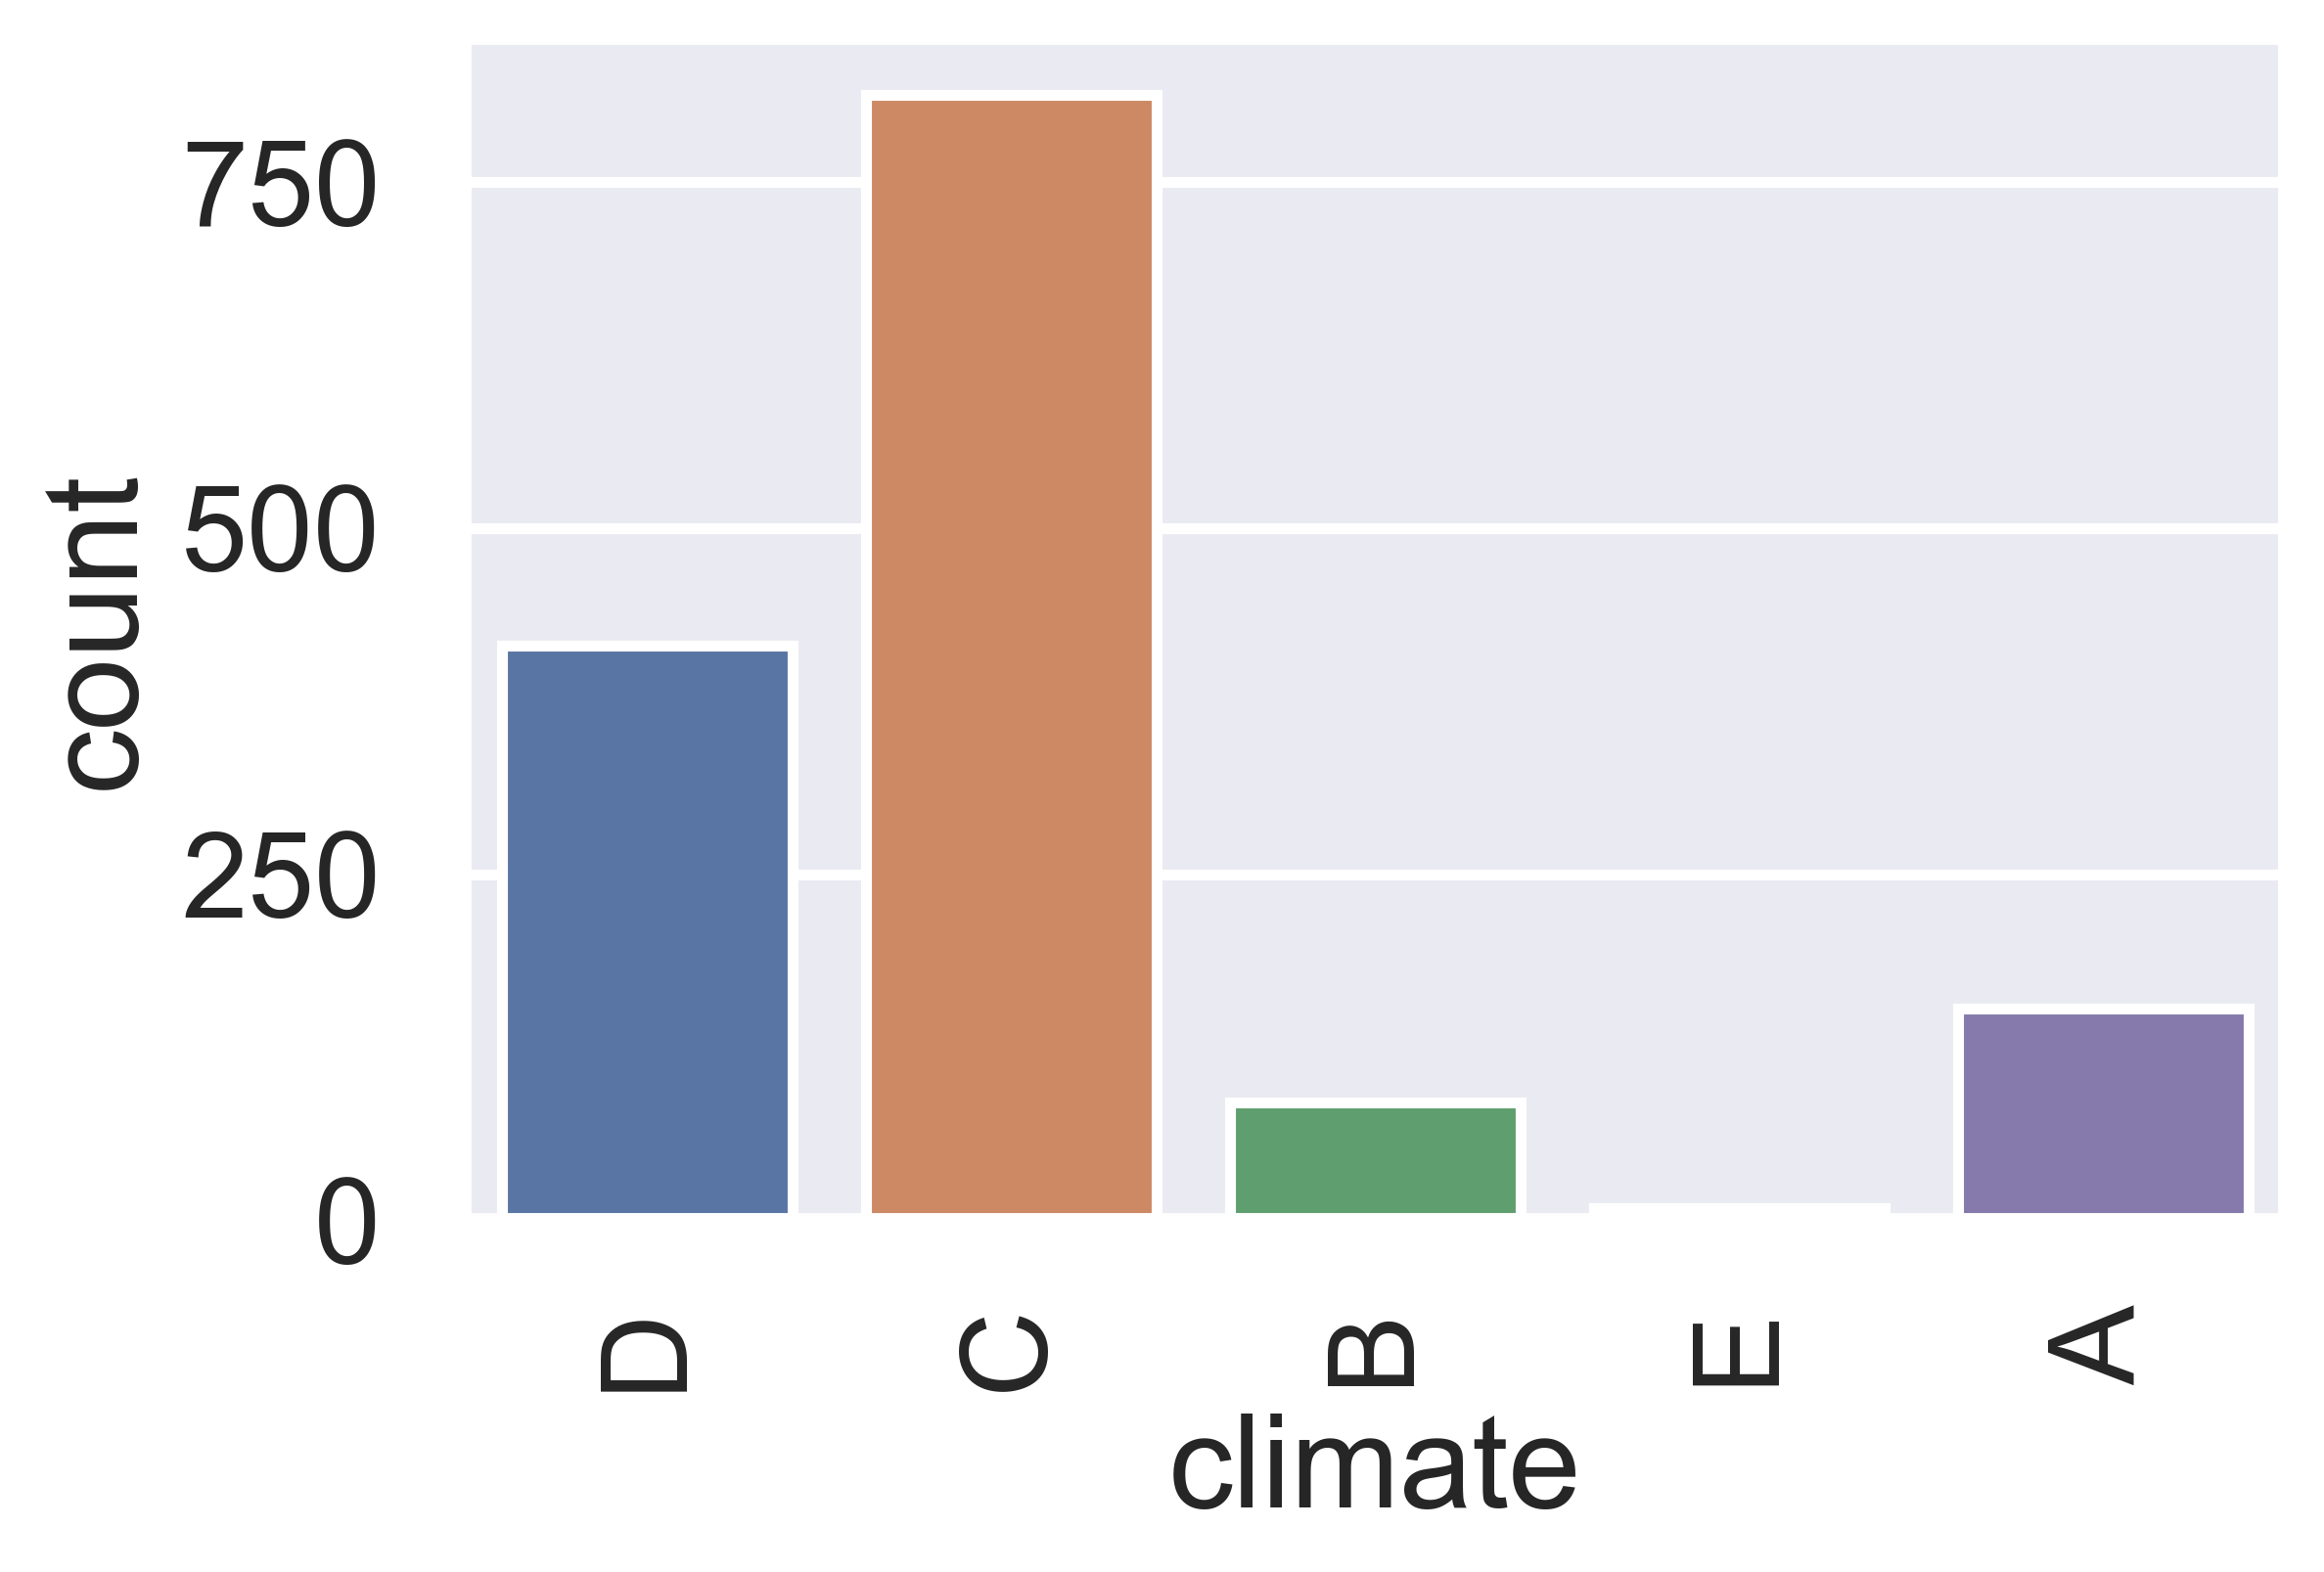

In [35]:
summary_climate_df = pd.DataFrame([
        {
            'climate': climate,
        }
        for climate, plants in climate_to_plants_dict.items()
        for plant in plants
    ],
)

g = sns.countplot(
    data=summary_climate_df,
    x="climate",
)

g.tick_params(axis='x', rotation=90)

In [36]:
disease_vector = set(collapsed_plant_disease_df['disease_curie'].to_list())
len(disease_vector)

23

### Prepare plant-disease dicts

In [37]:
def get_non_binary_dict(df:pd.DataFrame):
    """Get plant-disease data dictionary based on citation counts"""
    
    non_binary_dict = {}
        
    for plant_curie, disease_curie, evidence in tqdm(
        df[['plant_curie', 'disease_curie', 'evidence']].values
    ):
        pmid = evidence.split('_')[0]

        if plant_curie not in non_binary_dict:
            non_binary_dict[plant_curie] = defaultdict(set)

        non_binary_dict[plant_curie][disease_curie].add(pmid)
    return non_binary_dict

In [38]:
disease_literature_non_binary_dict = get_non_binary_dict(literature_data)

100%|██████████| 129539/129539 [00:00<00:00, 635055.23it/s]


In [39]:
disease_db_non_binary_dict = get_non_binary_dict(database_data)

100%|██████████| 43163/43163 [00:00<00:00, 618052.64it/s]


### Calculate chemical similarity for plants in the same genus or family

In [40]:
def calculate_pearson(plant_1, plant_2, species_to_vectors):
    """Calculate pearson coeffiencient."""
    diseases_plant_1_dict = species_to_vectors[plant_1]
    diseases_plant_2_dict = species_to_vectors[plant_2]
    
    elements_in_plant_1 = []
    elements_in_plant_2 = []
    
    for disease in disease_vector:
        if disease in diseases_plant_1_dict:
            elements_in_plant_1.append(len(diseases_plant_1_dict[disease]))
        else:
            elements_in_plant_1.append(0)
            
        if disease in diseases_plant_1_dict:
            elements_in_plant_2.append(len(diseases_plant_2_dict[disease]))
        else:
            elements_in_plant_2.append(0)
    try:
        corr = pearsonr(elements_in_plant_1, elements_in_plant_2)
    except:
        corr = None, None
            
    return corr


def calculate_overlap_for_taxa_level(
    climate_dict,
    species_to_disease_dict,
    pair_type,
):
    similarity_list = []
    skipped = 0
    
    for _, species in tqdm(
        climate_dict.items(),
        desc='calculating similarity...',
        total=len(climate_dict),
    ):
        # Not enough species to calculate similarity
        if len(species) <= 1:
            skipped += 1
            continue
                        
        for plant_1, plant_2 in combinations(species, 2):
            
            if (
                plant_1 not in species_to_disease_dict or 
                plant_2 not in species_to_disease_dict
            ):
                continue
            
            # pearson coefficient
            corr_coeff, p_val = calculate_pearson(
                plant_1, plant_2, species_to_disease_dict
            )
            
            if not corr_coeff or pd.isna(corr_coeff):
                continue
            
            similarity_list.append({
                'plant_1': plant_1,
                'plant_2': plant_2,
                'pair_type': pair_type,
                'pearson_coefficient': corr_coeff,
            })    
            
    return pd.DataFrame(similarity_list)

In [41]:
lit_climate_similarity = calculate_overlap_for_taxa_level(
    climate_dict=climate_to_plants_dict, # genus to species
    species_to_disease_dict=disease_literature_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same climate',
)

calculating similarity...:   0%|          | 0/5 [00:00<?, ?it/s]/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
calculating similarity...: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


In [42]:
db_climate_similarity = calculate_overlap_for_taxa_level(
    climate_dict=climate_to_plants_dict, # genus to species
    species_to_disease_dict=disease_db_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same climate',
)

calculating similarity...: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


### Calculate disease similarity for non taxonomically related plants

In [43]:
def calculate_baseline_overlap(
    all_plants,
    climate_dict,
    species_to_disease_dict,
):
    """Calculate overlap (disease/chemical) for plants ensuring that they are not belonging 
    to the same family (taxonomically-related)."""
    
    # List to store the similarity/overlap for these non-taxonomically plants
    similarity_list = []
        
    species_to_climate = {
        plant: climate
        for climate, species in climate_dict.items()
        for plant in species
    }
    
    outdated_ids = set()
    
    # Ensure it is a list
    all_plants = list(all_plants)
    
    while len(similarity_list) < 100000:
        # Get two random plants
        plant_1, plant_2 = random.choices(all_plants, k=2)
        
        # Plants with a wrong identifier
        if plant_1 not in species_to_climate:
            outdated_ids.add(plant_1)
            continue
            
        if plant_2 not in species_to_climate:
            outdated_ids.add(plant_2)
            continue
                
        # Skip if the plants belong to the same family
        if species_to_climate[plant_1] == species_to_climate[plant_2]:
            continue  
        
        # pearson coefficient
        corr_coeff, p_val = calculate_pearson(
            plant_1, plant_2, species_to_disease_dict
        )
        
        if not corr_coeff:
            continue

        similarity_list.append({
            'plant_1': plant_1,
            'plant_2': plant_2,
            'pair_type': 'Random',
            'pearson_coefficient': corr_coeff,
        })
            
    return pd.DataFrame(similarity_list), outdated_ids

In [44]:
lit_baseline_similarity, lit_outdated_ids = calculate_baseline_overlap(
    all_plants=plant_lit_ids,
    climate_dict=climate_to_plants_dict,
    species_to_disease_dict=disease_literature_non_binary_dict,
)

In [45]:
db_baseline_similarity, db_outdated_ids = calculate_baseline_overlap(
    all_plants=plant_db_ids,
    climate_dict=climate_to_plants_dict,
    species_to_disease_dict=disease_db_non_binary_dict,
)

In [46]:
len(lit_outdated_ids), len(db_outdated_ids)

(3483, 1805)

In [48]:
lit_merged_df = pd.concat([
    lit_climate_similarity,
    lit_baseline_similarity,
])

In [49]:
df_merged_df = pd.concat([
    db_climate_similarity,
    db_baseline_similarity,
])

### Plant-plant pair counts

In [50]:
lit_climate_pairs = lit_merged_df[lit_merged_df['pair_type'] == 'Same climate']
db_climate_pairs = df_merged_df[df_merged_df['pair_type'] == 'Same climate']

# Get pairs
lit_climate_pairs['pairs'] = lit_climate_pairs['plant_1'] + '_' + lit_climate_pairs['plant_2']
db_climate_pairs['pairs'] = db_climate_pairs['plant_1'] + '_' + db_climate_pairs['plant_2']


# All pairs
lit_gpairs = set(lit_climate_pairs['pairs'].values)
db_gpairs = set(db_climate_pairs['pairs'].values)

climate_pairs = lit_gpairs.union(db_gpairs)
len(climate_pairs), len(lit_gpairs), len(db_gpairs)

(336485, 281252, 92043)

### Similarity plot

In [ ]:
fig = plt.figure(figsize=(18, 11)) 

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)

suptitle = plt.suptitle(
    'Indication area similarity between \nclimatically-close and distant medicinal plants',
    y=0.99,
    fontweight='bold'
)

sns.violinplot(data=lit_merged_df, x='pair_type', y='pearson_coefficient', ax=ax1)
add_stat_annotation(
    data=lit_merged_df,
    x='pair_type',
    y='pearson_coefficient',
    ax=ax1,
    box_pairs=[
       ("Same climate", "Random"), 
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax1.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
# ax1.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax1.set_ylabel("Pearson correlation")
ax1.set_xlabel("")
ax1.set_title("Scientific literature", y=1.02)

sns.violinplot(data=df_merged_df, x='pair_type', y='pearson_coefficient', ax=ax2)
add_stat_annotation(
    data=df_merged_df,
    x='pair_type',
    y='pearson_coefficient',
    ax=ax2,
    box_pairs=[
       ("Same climate", "Random"), 
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax2.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
# ax2.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax2.set_ylabel("")
ax2.set_xlabel("")

ax2.set_title("Ethnobotanical databases", y=1.02)
    
plt.tight_layout()
plt.savefig(
    f'../data/figures/supplementary_figure_1.png',
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same climate v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.111e-12 U_stat=1.492e+10
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same climate v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.924e-10 U_stat=4.895e+09


In [52]:
for col in lit_merged_df.pair_type.unique():
    info = lit_merged_df[lit_merged_df.pair_type == col]
    print(
        f'Disease area similarity (literature) for {col} \
        mean: {info["pearson_coefficient"].mean():.3f}, \
        median: {info["pearson_coefficient"].median():.3f}'
    )

Disease area similarity (literature) for Same climate         mean: 0.146,         median: 0.052
Disease area similarity (literature) for Random         mean: 0.139,         median: 0.038


In [53]:
for col in df_merged_df.pair_type.unique():
    info = df_merged_df[df_merged_df.pair_type == col]
    print(
        f'Disease area similarity (databases) for {col} \
        mean: {info["pearson_coefficient"].mean():.3f}, \
        median: {info["pearson_coefficient"].median():.3f}'
    )

Disease area similarity (databases) for Same climate         mean: 0.194,         median: 0.186
Disease area similarity (databases) for Random         mean: 0.184,         median: 0.171
